# Select dispatching rules using support vector machines

This notebook presents an implementation of a support vector machine for dynamically selecting dispatching rules based on the system state.

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import time
import sys
import shap
import pandas as pd
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from time import mktime

tqdm.pandas()

sys.path.append("..")
from src.models import train_pipeline_model, evaluate_pipeline,  optimize_hyperparameters, plot_learning_curve
from src.utils import get_hyperparameter_number
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt, \
    assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, run_simulation_complete

## Get required data

In [2]:
# Load the training data
with open(r"../data/processed/data_processed_classification_training.pickle", "rb") as output_file:
    data_train = pickle.load(output_file)

In [3]:
# Load the validation data
with open(r"../data/processed/data_processed_classification_validation.pickle", "rb") as output_file:
    data_validation = pickle.load(output_file)

In [4]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [5]:
# Define constants for model training
RANDOM_STATE = 42
numeric_features = list(data_train.columns)
numeric_features.remove("priority_rule_start")
numeric_features.remove("priority_rule_score")
categorical_features =  ["priority_rule_start"]

In [6]:
# Define constants for simulation
priority_rules = {"edd": assign_priority_edd,
                  "spt": assign_priority_spt,
                  "srpt": assign_priority_srpt,
                  "fifo": assign_priority_fifo,
                  "cr": assign_priority_cr,
                  "mdd": assign_priority_mdd,
                  "lpt": assign_priority_lpt,
                  "ds": assign_priority_ds}
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list =  [40, 50, 60, 70]
random_states = [100, 101, 102]

# Prepare data

In [7]:
# Define features and flag
X = data_train.drop("priority_rule_score",  axis = 1)
y = data_train[["priority_rule_score"]]
X_validate = data_validation.drop("priority_rule_score",  axis = 1)
y_validate = data_validation[["priority_rule_score"]]

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model training

## Baseline

In [9]:
# Simple dummy classifier based on the maximization of the prior probability
dummy = DummyClassifier(strategy="prior", random_state=42)
dummy_fit = dummy.fit(X_train, y_train)
print(f"Accuracy of the dummy classifier is: {round(dummy_fit.score(X_test, y_test), 4)}")

Accuracy of the dummy classifier is: 0.2418


In [10]:
# Simple logistic regression baseline without hyperparameter tuning and feature selection
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)
pipeline_lr = train_pipeline_model(lr, X_train, y_train, numeric_features, categorical_features)
evaluate_pipeline(pipeline_lr, X_test, y_test)

Start at 11:1:1
Duration: 12.545658111572266
Start at 11:1:13
Accuracy: 0.46142578125
F1: 0.43263465330364026
Precision: 0.44603803103803535
Recall: 0.42746990199377655
Duration: 0.2924168109893799


## Hyperparameter search

In [11]:
# Define set of hyperparameters
params_svm = {"classifier__max_iter": [250, 500, 1000],
              "classifier__loss": ["hinge", "squared_hinge"],
              'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'classifier__tol': [0.0001, 0.001],
              'classifier__multi_class' : ["ovr", "crammer_singer"],
            'feature_selection__n_components': [10, 20, 50, "mle"]
             }
print(f"Set of {get_hyperparameter_number(params_svm)} hyperparameters")

Set of 576 hyperparameters


Based on the variables we executed a grid hyperparameter search using successful halving.

In [12]:
# Fit hyperparameter search
# model = LinearSVC(random_state=RANDOM_STATE)
# feature_selector = PCA(random_state = RANDOM_STATE)
# fitted_clf = optimize_hyperparameters(X_train, y_train, model, feature_selector,numeric_features, categorical_features, params_svm, RANDOM_STATE)
# print(fitted_clf.best_params_)
# pd.DataFrame(fitted_clf.cv_results_).to_csv("../data/processed/hyperparameter_search/results_hyperparameter_support_vector_machine.csv", index = False)

The grid search was executed and took 10027.54 seconds. The results are saved in a dataframe and can be read in as a csv file.

In [13]:
# Load hyperparameter results
results_hyperparameter = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_support_vector_machine.csv")

The resulting set of optimal hyperparameter were:
**Support Vector Machine**
* C = 1.0
* loss = "squared_hinge"
* max_iter = 500
* multi_class = "ovr"
* tol = 0.001

**PCA**
* n_components = "mle"

## Train final model

Train model for evaluation based on the select hyperparameter.

In [14]:
# Train pipeline based on hyperparameter
# Duration ~ 2 minutes
final_model = LinearSVC(random_state=RANDOM_STATE, C = 1.0, loss = "squared_hinge", max_iter = 500, multi_class = "ovr", tol = 0.001)
final_feature_selector = PCA(n_components = "mle", random_state = RANDOM_STATE)
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)

In [15]:
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_support_vector_machine_training.joblib')

In [16]:
# Load trained model
pipeline_trained = load('../models/pipeline_dispatching_classification_support_vector_machine_training.joblib')

## Model evaluation

In [17]:
# Evaluate pipeline on train
evaluate_pipeline(pipeline_trained, X_train, y_train)

Start at 11:1:14
Accuracy: 0.4491916232638889
F1: 0.4066461204584919
Precision: 0.4483448766148485
Recall: 0.40210006077279525
Duration: 0.9137401580810547


In [18]:
# Evaluate pipeline on test
evaluate_pipeline(pipeline_trained, X_test, y_test)

Start at 11:1:15
Accuracy: 0.4442274305555556
F1: 0.40013535416477347
Precision: 0.4374326856531643
Recall: 0.3966993769002539
Duration: 0.28953003883361816


In [19]:
# Plot learning curve based on data samples and fitting time
# May take some seconds to calculate
# plot_learning_curve(
#         pipeline_trained,
#         "Evaluation training set support vector machine",
#         X,
#         y.values.ravel(),
#         axes=None,
#         ylim=None,
#         cv=None,
#         n_jobs=-1,
#         scoring="accuracy",
#         train_sizes=np.linspace(0.1, 1.0, 5))

We see that the training and test scores are approximating each other showing that the model learnt something without overfitting. However, more data seem not necessary to be able to potentially improve the model.

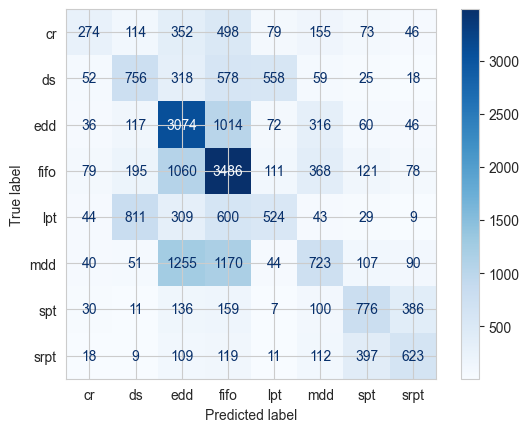

In [20]:
# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(
        pipeline_trained,
        X_validate,
        y_validate,
        cmap=plt.cm.Blues)

In [21]:
# Get feature names
# feature_names = pipeline_trained["preprocessor"].get_feature_names_out(X_validate.columns)

In [22]:
# Calculate importance
# Duration ~ 90 minutes
# importance = permutation_importance(pipeline_trained, X_validate, y_validate,
#                            n_repeats=100,
#                            random_state=0)

In [23]:
# Visualize result
# fig, ax = plt.subplots()
# indices = importance['importances_mean'].argsort()[0:20]
# plt.barh(range(len(indices)),
#              importance['importances_mean'][indices],
#              xerr=importance['importances_std'][indices])
#
# ax.set_yticks(range(len(indices)))
# _ = ax.set_yticklabels(feature_names[indices])

## Train full model

Train the full model based on all available data. The training duration is around 137.45 seconds.

In [24]:
# Create combined dataset for training the final model
X_complete = pd.concat([X, X_validate])
y_complete = pd.concat([y, y_validate])

In [25]:
# Train pipeline based on hyperparameter
final_model = LinearSVC(random_state=RANDOM_STATE, C = 1.0, loss = "squared_hinge", max_iter = 500, multi_class = "ovr", tol = 0.001)
final_feature_selector = PCA(n_components = "mle", random_state = RANDOM_STATE)
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_support_vector_machine_complete.joblib')

In [26]:
# Load trained model
pipeline_simulation = load('../models/pipeline_dispatching_classification_support_vector_machine_complete.joblib')

# Evaluation in simulation environment

In this section we define a simulation testing environment for testing and comparing the performance of different approaches. For this we create use repeated simulation of a factory with varying experiment settings. The trained algorithm are then used in the process to select dispatching rules.

In [27]:
# Execute simulation
# Duration ~23 minutes
# simulation_results = run_simulation_complete(pipeline_simulation, priority_rules, random_states, due_date_range_list,
#                                             number_orders_start_list,
#                                             average_count_new_orders_list, worker_list, "Support Vector Classification",
#                                             product_types_df, machines_df, orders_df, SIMULATION_START)

In [28]:
# Save simulation results
# simulation_results.to_csv("../data/processed/evaluation/simulation_results_validation_classification_support_vector_machine.csv", index = False)

In [29]:
# Analyse simulation results profit
simulation_results = pd.read_csv("../data/processed/evaluation/simulation_results_validation_classification_support_vector_machine.csv")
simulation_results["profit"] = simulation_results["revenue"] - simulation_results["penalty"]
print(f"Average profit is: {simulation_results.profit.mean()}")

Average profit is: 7318.10727384259


<AxesSubplot: xlabel='day', ylabel='profit'>

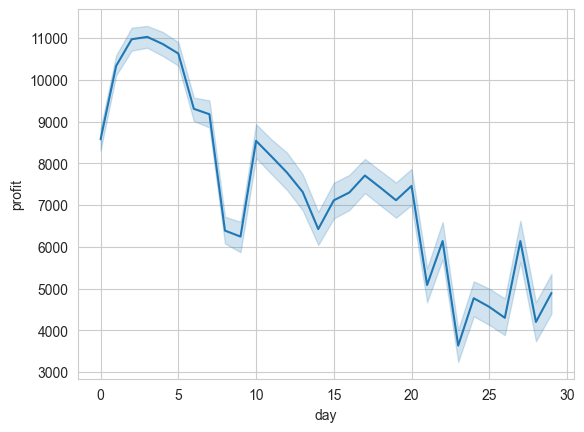

In [30]:
# Visualize profit
sns.lineplot(simulation_results, x = "day", y = "profit")

<AxesSubplot: xlabel='day', ylabel='profit'>

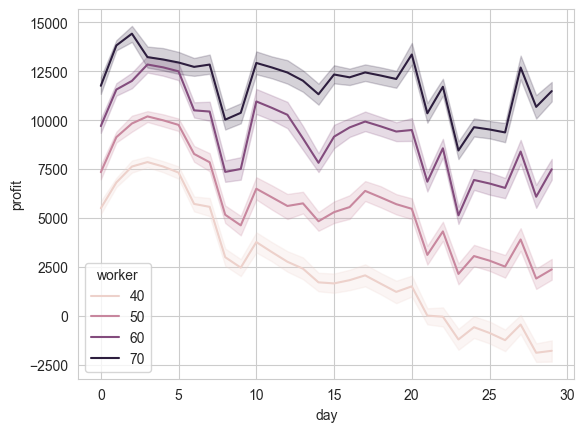

In [31]:
# Visualize profit per worker constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "worker")

<AxesSubplot: xlabel='day', ylabel='profit'>

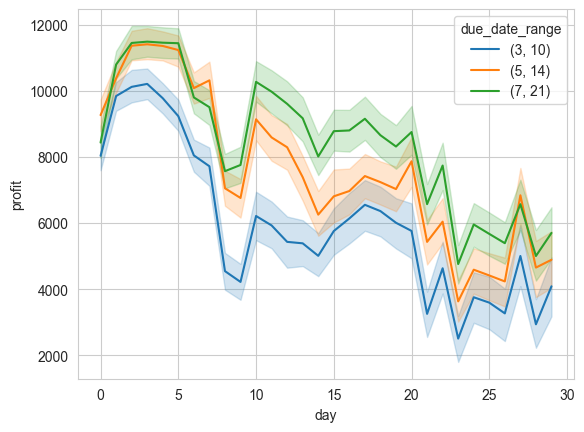

In [32]:
# Visualize profit per due date constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "due_date_range")

<AxesSubplot: xlabel='day', ylabel='profit'>

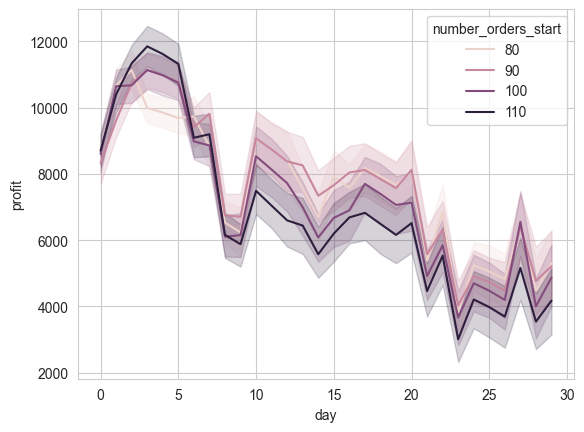

In [33]:
# Visualize profit per number_orders_start constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "number_orders_start")

<AxesSubplot: xlabel='day', ylabel='profit'>

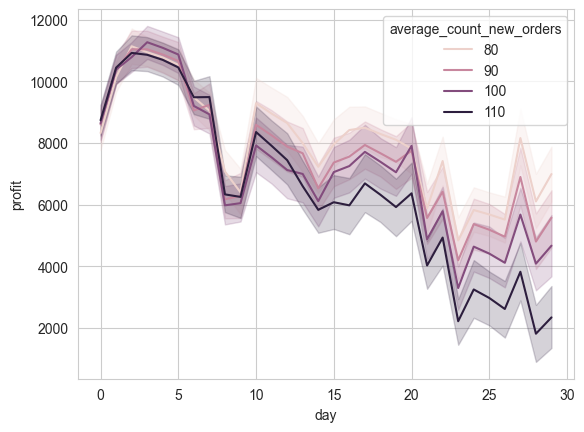

In [34]:
# Visualize profit per average count new orders constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "average_count_new_orders")